# Big Mart Sales Prediction

We will explore the data Big Mart Outlet Sales dataset from Kaggle (https://www.kaggle.com/brijbhushannanda1979/bigmart-sales-data). The dataset consists of 14203 points and 13 features.

The goal is to predict the sales for items in a given store based on a variety of parameters.

In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso,Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRFRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
!ls

bigmartsales.ipynb  submission.csv  test_AbJTz2l.csv  train_v9rqX0R.csv


# Data Description

Load the data and combine train and test sets for exploration and cleaning

In [3]:
data_train = pd.read_csv("train_v9rqX0R.csv")
data_test = pd.read_csv("test_AbJTz2l.csv")
data_train["source"] = "train"
data_test["source"] = "test"

In [4]:
data = pd.concat([data_train,data_test],ignore_index=True)

In [5]:
data.shape

(14204, 13)

In [6]:
data.head()

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,source
0,Low Fat,FDA15,249.8092,3735.1380,Dairy,0.016047,9.30,1999,OUT049,Tier 1,Medium,Supermarket Type1,train
1,Regular,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.92,2009,OUT018,Tier 3,Medium,Supermarket Type2,train
2,Low Fat,FDN15,141.6180,2097.2700,Meat,0.016760,17.50,1999,OUT049,Tier 1,Medium,Supermarket Type1,train
3,Regular,FDX07,182.0950,732.3800,Fruits and Vegetables,0.000000,19.20,1998,OUT010,Tier 3,NaN,Grocery Store,train
4,Low Fat,NCD19,53.8614,994.7052,Household,0.000000,8.93,1987,OUT013,Tier 3,High,Supermarket Type1,train


In [7]:
data.columns

Index(['Item_Fat_Content', 'Item_Identifier', 'Item_MRP', 'Item_Outlet_Sales',
       'Item_Type', 'Item_Visibility', 'Item_Weight',
       'Outlet_Establishment_Year', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Size', 'Outlet_Type', 'source'],
      dtype='object')

In [8]:
data.dtypes

Item_Fat_Content              object
Item_Identifier               object
Item_MRP                     float64
Item_Outlet_Sales            float64
Item_Type                     object
Item_Visibility              float64
Item_Weight                  float64
Outlet_Establishment_Year      int64
Outlet_Identifier             object
Outlet_Location_Type          object
Outlet_Size                   object
Outlet_Type                   object
source                        object
dtype: object

We have a healthy mix of categorical and continuous variables. All the object types must be converted to int/float type before building the model.

In [9]:
data.describe()

,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Establishment_Year
count,14204.000000,8523.000000,14204.000000,11765.000000,14204.000000
mean,141.004977,2181.288914,0.065953,12.792854,1997.830681
std,62.086938,1706.499616,0.051459,4.652502,8.371664
min,31.290000,33.290000,0.000000,4.555000,1985.000000
25%,94.012000,834.247400,0.027036,8.710000,1987.000000
50%,142.247000,1794.331000,0.054021,12.600000,1999.000000
75%,185.855600,3101.296400,0.094037,16.750000,2004.000000
max,266.888400,13086.964800,0.328391,21.350000,2009.000000


In [10]:
(data.isnull().sum()/data.shape[0]*100)

Item_Fat_Content              0.000000
Item_Identifier               0.000000
Item_MRP                      0.000000
Item_Outlet_Sales            39.995776
Item_Type                     0.000000
Item_Visibility               0.000000
Item_Weight                  17.171219
Outlet_Establishment_Year     0.000000
Outlet_Identifier             0.000000
Outlet_Location_Type          0.000000
Outlet_Size                  28.273726
Outlet_Type                   0.000000
source                        0.000000
dtype: float64

There are three features that have NULL values:

1. Item_Outlet_Sales: Our dependent variable. Must be noted that the null values are wholly because we have concatenated the already given train and test datasets. The test dataset does not contain  values for number of sales and is filled with NULLs

2. Item_Weight: Might be an important feature in predicting sales. So it does not make sense to remove the values completely. Lets decide how to impute with further exploration. 

3. Outlet_Size: Might be very crucial in predicting our dependent variables. Not unlike above, will require further exploration

# Exploratory Data Analysis

## Item Sales

The first feature I usually explore is the dependent variable. It gives a statistical description about the goal. And more importantly, if there is any feature engineering to do, it is better to do it first as we will further explore the relationship of the independent variables with the dependent variable.

In [11]:
data['Item_Outlet_Sales'].describe()

count     8523.000000
mean      2181.288914
std       1706.499616
min         33.290000
25%        834.247400
50%       1794.331000
75%       3101.296400
max      13086.964800
Name: Item_Outlet_Sales, dtype: float64

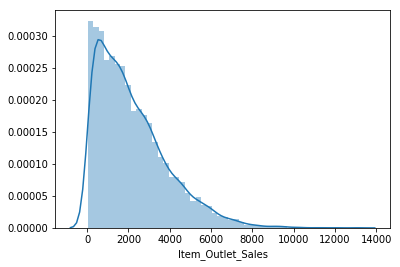

In [12]:
sns.distplot(data['Item_Outlet_Sales'])

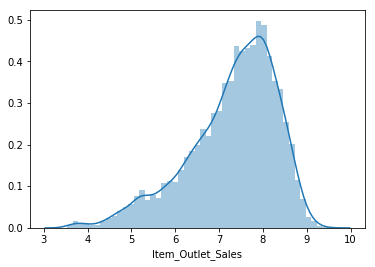

In [13]:
sns.distplot(np.log1p(data['Item_Outlet_Sales']))

In [14]:
data['log_sales'] = np.log1p(data['Item_Outlet_Sales'])

By taking the log of the dependent variable it seems to be more normally distributed which may help some algorithms to generalize much better. We can train on both and see which works out better.

## Item Weight

I can assume that lighter items may sell out more because of the ease they present. However lets dive in to check more.

In [15]:
print('# of NULL Values:',data['Item_Weight'].isnull().sum())

# of NULL Values: 2439


We do not want to lose out on all this data especially since it is around 20 percent of the total. The best strategy is to impute the NaNs. We know that we have an identifier for each product. The same product must have the same weight. Let us use a pivot to get the weights of each product and replace the NaNs

In [16]:
weight_pivot_table = data.pivot_table(values='Item_Weight', index='Item_Identifier')
weight_pivot_table.head()

,Item_Weight
Item_Identifier,
DRA12,11.600
DRA24,19.350
DRA59,8.270
DRB01,7.390
DRB13,6.115


In [17]:
missing_weights = data["Item_Weight"].isnull()
data.loc[missing_weights,"Item_Weight"] = data.loc[missing_weights,"Item_Identifier"].apply(lambda x: weight_pivot_table.loc[x])

In [18]:
print('# of NULL Values:',data['Item_Weight'].isnull().sum())

# of NULL Values: 0


Now that we have removed the NaNs let us see the statiscal properties and the relationship with the dependent variable

In [19]:
data['Item_Weight'].describe()

count    14204.000000
mean        12.793380
std          4.651716
min          4.555000
25%          8.710000
50%         12.600000
75%         16.750000
max         21.350000
Name: Item_Weight, dtype: float64

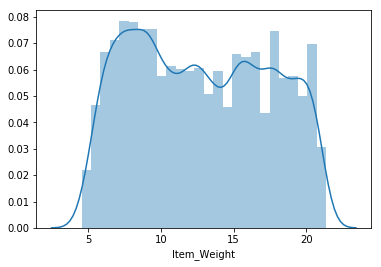

In [20]:
sns.distplot(data['Item_Weight'])

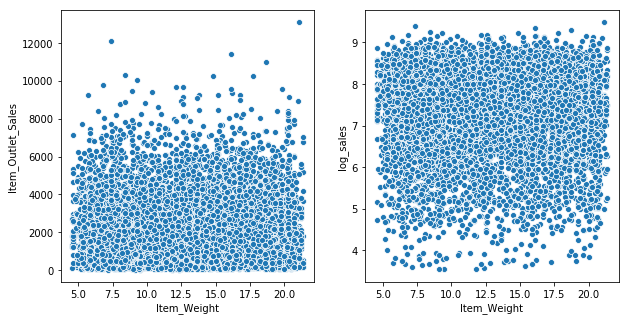

In [21]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
sns.scatterplot(data['Item_Weight'], data['Item_Outlet_Sales'], ax=ax[0])
sns.scatterplot(data['Item_Weight'], data['log_sales'], ax=ax[1])

Wow ! It could not be any clear. There is no decernible correlation between the weight and the two dependent variables. Looks like our earlier assumption was inaccurate

In [22]:
print(data[data['Item_Weight'] < 5]['log_sales'].mean())
print(data[(data['Item_Weight'] >= 5) & (data['Item_Weight'] <= 10)]['log_sales'].mean())
print(data[(data['Item_Weight'] >= 10) & (data['Item_Weight'] <= 15)]['log_sales'].mean())
print(data[(data['Item_Weight'] >= 15) & (data['Item_Weight'] <= 25)]['log_sales'].mean())

7.463090424534277
7.28682045797702
7.306344844312462
7.299582355067533


Even if we divide the weights into buckets, the sales are fairly distributed. Let us keep the feature for now. We may try training models with and without it.

## Outlet Size

On the onset, Outlet Size may matter a lot while predicting sales. Intuitively, larger stores may sell more.

In [23]:
print('# of NULL Values:',data['Outlet_Size'].isnull().sum())

# of NULL Values: 4016


This is huge ! We do not want to lose out on so many values. Let us borrow a leaf from Item_Weights book. Since this is a categorical variable, let us check the mode of Outlet Size for each type in Outlet_Type. We can also check the individual splits to make sure Outlet_Type is the right variable w pivot to impute for Outlet_Size

In [24]:
data.pivot_table(index="Outlet_Type", values="Outlet_Size",aggfunc=mode)

,Outlet_Size
Outlet_Type,
Grocery Store,"([Small], [880])"
Supermarket Type1,"([Small], [3100])"
Supermarket Type2,"([Medium], [1546])"
Supermarket Type3,"([Medium], [1559])"


In [25]:
print(data[data['Outlet_Type'] == "Grocery Store"]["Outlet_Size"].value_counts())
print(data[data['Outlet_Type'] == "Supermarket Type1"]["Outlet_Size"].value_counts())
print(data[data['Outlet_Type'] == "Supermarket Type2"]["Outlet_Size"].value_counts())
print(data[data['Outlet_Type'] == "Supermarket Type3"]["Outlet_Size"].value_counts())

Small    880
Name: Outlet_Size, dtype: int64
Small     3100
High      1553
Medium    1550
Name: Outlet_Size, dtype: int64
Medium    1546
Name: Outlet_Size, dtype: int64
Medium    1559
Name: Outlet_Size, dtype: int64


Looks Great ! In fact its a perfect split for 3 of the four Outlet_Types. To be more clear, when Outlet_Type == Grocery Store, Outlet_Size is always Small and so on. We can use this to fill in the NaNs in Outlet_Size by checking the Outlet_Type.

In [26]:
missing_out_size = data['Outlet_Size'].isnull()

In [27]:
def func1(x):
    if x == 'Grocery Store' or x == 'Supermarket Type1':
        return 'Small'
    else:
        return 'Medium'

In [28]:
data.loc[missing_out_size,'Outlet_Size'] = data.loc[missing_out_size,'Outlet_Type'].apply(func1)

In [29]:
print('# of NULL Values:',data['Outlet_Size'].isnull().sum())

# of NULL Values: 0


In [30]:
data['Outlet_Size'].value_counts()

Small     7996
Medium    4655
High      1553
Name: Outlet_Size, dtype: int64

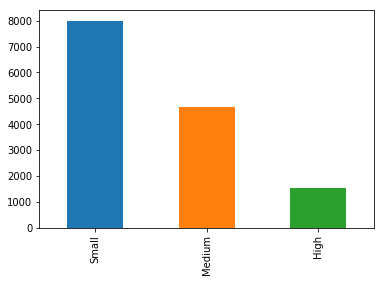

In [31]:
data['Outlet_Size'].value_counts().plot(kind='bar')

It seems most of the stores are small and medium

In [32]:
data.pivot_table(values=['Item_Outlet_Sales','log_sales'], index='Outlet_Size')

,Item_Outlet_Sales,log_sales
Outlet_Size,,
High,2298.995256,7.475972
Medium,2681.603542,7.630472
Small,1867.182814,7.069649


This is key. Oulet Size like we assumed is a good indicator of the number of sales. In fact it is the medium sized stores that make the highest average sales followed by large and then small.

## Outlet Type

Like its predecessor, I expect outlet type to describe our sales well. Only one way to find out

In [33]:
print('# of NULL Values:',data['Outlet_Type'].isnull().sum())

# of NULL Values: 0


In [34]:
data['Outlet_Type'].value_counts()

Supermarket Type1    9294
Grocery Store        1805
Supermarket Type3    1559
Supermarket Type2    1546
Name: Outlet_Type, dtype: int64

In [35]:
data.pivot_table(values=['Item_Outlet_Sales','log_sales'], index='Outlet_Type')

,Item_Outlet_Sales,log_sales
Outlet_Type,,
Grocery Store,339.828500,5.551226
Supermarket Type1,2316.181148,7.509277
Supermarket Type2,1995.498739,7.332110
Supermarket Type3,3694.038558,8.025963


Short and sweet. No missing values. Types are good distinguishers of the amount of sales to expect. Grocery Store amount for the lowest sales. Remember, they are all small shops and going by the name, may sell limited items. .

It would be interesting to check the correlation between Outlet_Type and Outlet_Size. If they are highly correlated, it makes little sense to use both features in our model.

## Outlet Location Type

We may get to analyze the buying patterns for stores in different tier cities. One may assume that people in bigger cities have greater purchasing power and may account for greater sales. However, bigger cities also offer greater Store competetion and people may choose to buy from stores other than Big Mart. 

In [36]:
print('# of NULL Values:',data['Outlet_Location_Type'].isnull().sum())

# of NULL Values: 0


In [37]:
data['Outlet_Location_Type'].value_counts()

Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64

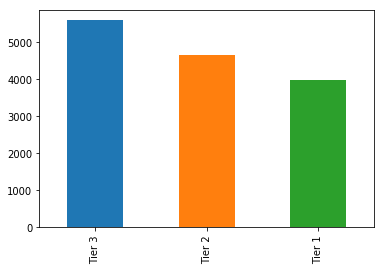

In [38]:
data['Outlet_Location_Type'].value_counts().plot(kind='bar')

Nice to see that the penetration of markets in smaller cities is greater than bigger cities. Big Mart may be thinking along the lines of out latter assumption.

In [39]:
data.pivot_table(values=['Item_Outlet_Sales','log_sales'], index='Outlet_Location_Type')

,Item_Outlet_Sales,log_sales
Outlet_Location_Type,,
Tier 1,1876.909159,7.083557
Tier 2,2323.990559,7.516337
Tier 3,2279.627651,7.269002


Our latter assumption may indeed be right. Tier 2 and 3 cities account for greater sales as compared to tier 1. This categorical split may help our model generaliz better.

## Item Visibility

This is a tricky feature. It accounts for the percentage visibility given to a particular product in a particular store. We may need to do some feature engineering to make better use of this feature.

In [40]:
print('# of NULL Values:',data['Item_Visibility'].isnull().sum())

# of NULL Values: 0


In [41]:
data['Item_Visibility'].describe()

count    14204.000000
mean         0.065953
std          0.051459
min          0.000000
25%          0.027036
50%          0.054021
75%          0.094037
max          0.328391
Name: Item_Visibility, dtype: float64

In [42]:
print('# of Zero values:',data[data['Item_Visibility'] == 0].shape[0])

# of Zero values: 879


A lot of our items have zero visibility. Which seems impractical. Store keepers may have missed filling out some and they may have defaulted to zero. We can replace them with the average visibility a particular product has across storesfor a more accurate assessment than zero. It must be noted that the visibility may differ considerably across stores but an average can still describe it better.

In [43]:
vis_pivot_table = data.pivot_table(values='Item_Visibility', index='Item_Identifier')
vis_pivot_table.head()

,Item_Visibility
Item_Identifier,
DRA12,0.034938
DRA24,0.045646
DRA59,0.133384
DRB01,0.079736
DRB13,0.006799


In [44]:
zero_vis = data['Item_Visibility'] == 0
data.loc[zero_vis,"Item_Visibility"] = data.loc[zero_vis,"Item_Identifier"].apply(lambda x: vis_pivot_table.loc[x])

In [45]:
print('# of Zero values:',data[data['Item_Visibility'] == 0].shape[0])

# of Zero values: 0


In [46]:
print(data[data['Item_Visibility']>0.1]['Item_Outlet_Sales'].mean())
print(data[(data['Item_Visibility']>0.05) & (data['Item_Visibility']<0.1)]['Item_Outlet_Sales'].mean())
print(data[(data['Item_Visibility']>0) & (data['Item_Visibility']<0.05)]['Item_Outlet_Sales'].mean())

1849.5055994074096
2275.1595210294145
2291.5412055055554


Let us check the average sales in differet bands of visibility. This looks highly counter-intuitive. It seems that those items with lesser visibility has been selling out greater than that with greater. Maybe its because of the amount of data in my assumed bands.

Also, it also makes more sense to incorporate the visbility of a product with respect to the average visibility across stores to have greater unbiasedness. For instance, item A may be selling out more in store X as it is more visbile. It does not necessarily mean that the Item is in greater demand. A ratio would be more representative.

In [47]:
data['Item_Visibility_Ratio'] = data.apply(lambda x: x['Item_Visibility']/vis_pivot_table.loc[x['Item_Identifier']], axis=1)

In [48]:
data['Item_Visibility_Ratio'].describe()

count    14204.000000
mean         1.061884
std          0.235907
min          0.844563
25%          0.925131
50%          0.999070
75%          1.042007
max          3.010094
Name: Item_Visibility_Ratio, dtype: float64

In [49]:
print(data[data['Item_Visibility_Ratio'] < 1]['Item_Outlet_Sales'].mean())
print(data[(data['Item_Visibility_Ratio']>1) & (data['Item_Visibility_Ratio']<2)]['Item_Outlet_Sales'].mean())
print(data[(data['Item_Visibility_Ratio']>2)]['Item_Outlet_Sales'].mean())

2464.8973582890194
1857.8309417400867
343.6193799999999


There seems to be a much greater split when we use the engineered ratio. This would help make the model better.

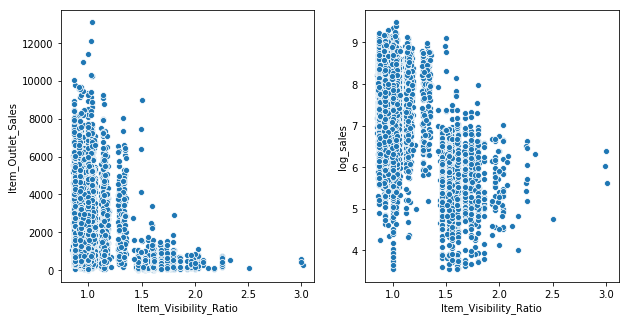

In [50]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
sns.scatterplot(data['Item_Visibility_Ratio'], data['Item_Outlet_Sales'], ax=ax[0])
sns.scatterplot(data['Item_Visibility_Ratio'], data['log_sales'], ax=ax[1])

However, there isnt a distinctive correlation trend with respect to the dependent variables.

## Item Type

The type of Item may present to be a big factor in the Items sold. Let us look at the different types of goods and the units sold

In [51]:
print('# of NULL Values:',data['Item_Type'].isnull().sum())

# of NULL Values: 0


In [52]:
data['Item_Type'].value_counts()

Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

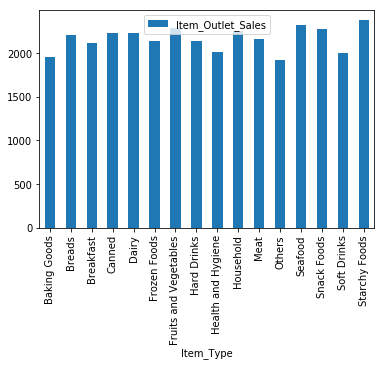

In [53]:
data.pivot_table(values='Item_Outlet_Sales', index='Item_Type').plot(kind='bar')

It seems there are a lot if categories in the Item_Type feature. Whsts worse is that there is almost a uniform amount of sales when it comes to each category. Perhaps we can find a more general Item Type to classify them into.

Upon Inspection, it seems that the Item_Identifier feature has a code that the first two charecters represent a particular category. 

In [54]:
data['Item_Identifier'].head()

0    FDA15
1    DRC01
2    FDN15
3    FDX07
4    NCD19
Name: Item_Identifier, dtype: object

In [55]:
data['Item_Cat'] = data['Item_Identifier'].apply(lambda x: x[:2])

Let us extract those characters and store them into Item_Cat. The three types correspond to Drink, Food, Non Consummable

In [56]:
data.pivot_table(values=['Item_Outlet_Sales','log_sales'], index='Item_Cat')

,Item_Outlet_Sales,log_sales
Item_Cat,,
DR,1997.333337,7.199265
FD,2215.354223,7.313369
NC,2142.721364,7.287737


## Fat Content

In [57]:
print('# of NULL Values:',data['Item_Fat_Content'].isnull().sum())

# of NULL Values: 0


In [58]:
data['Item_Fat_Content'].value_counts()

Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

First, lets clean up the feature a little and merge repeat categories

In [59]:
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({
    "LF":"Low Fat",
    "reg":"Regular",
    "low fat":"Low Fat"
})

In [60]:
data['Item_Fat_Content'].value_counts()

Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64

In [61]:
data.loc[data["Item_Cat"] == "NC","Item_Fat_Content"].shape

(2686,)

Also, it seems a lot of Non-Consumable type items are classified as either of low fat or regular. Lets create a third category to demarcate that it is neither

In [62]:
data.loc[data["Item_Cat"] == "NC","Item_Fat_Content"] = "Non-Edible"

In [63]:
data["Item_Fat_Content"].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

In [64]:
data.pivot_table(values=['Item_Outlet_Sales','log_sales'], index='Item_Fat_Content')

,Item_Outlet_Sales,log_sales
Item_Fat_Content,,
Low Fat,2163.829268,7.289003
Non-Edible,2142.721364,7.287737
Regular,2224.561170,7.314798


## Item Max Retail Price

Price may be an indicator to suggest the number of sales. Let us see the relationship it holds with the dependent variables.

In [65]:
print('# of NULL Values:',data['Item_MRP'].isnull().sum())

# of NULL Values: 0


In [66]:
data['Item_MRP'].describe()

count    14204.000000
mean       141.004977
std         62.086938
min         31.290000
25%         94.012000
50%        142.247000
75%        185.855600
max        266.888400
Name: Item_MRP, dtype: float64

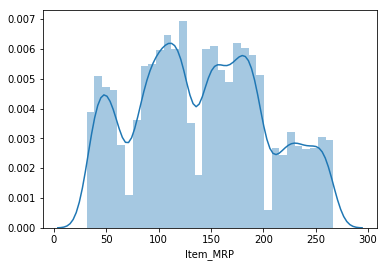

In [67]:
sns.distplot(data['Item_MRP'])

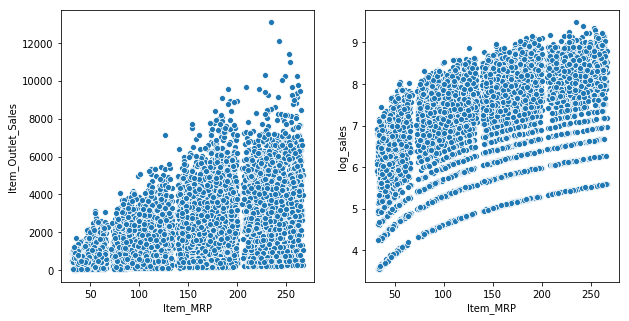

In [68]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
sns.scatterplot(data['Item_MRP'], data['Item_Outlet_Sales'], ax=ax[0])
sns.scatterplot(data['Item_MRP'], data['log_sales'], ax=ax[1])

There does seem to be some relationship between the price and the dependent variables

## Establishment Year

Should newer stores have greater sales ? It definitely does reflect on the performance of the management ? Lets see what the data tells us and weather this feature is important in predicting sales

In [69]:
print('# of NULL Values:',data['Outlet_Establishment_Year'].isnull().sum())

# of NULL Values: 0


In [70]:
data.groupby(['Outlet_Establishment_Year'])['Item_Outlet_Sales'].mean()

Outlet_Establishment_Year
1985    2483.677474
1987    2298.995256
1997    2277.844267
1998     339.351662
1999    2348.354635
2002    2192.384798
2004    2438.841866
2007    2340.675263
2009    1995.498739
Name: Item_Outlet_Sales, dtype: float64

It certainly dosent look like there is a huge difference in the number of sales based on the newness of the store. However, lets keep a years_of_existence variable instead of year established as a smaller number can make the model converge faster in some algorithms

In [71]:
data['Outlet_Establishment_Year'] = data['Outlet_Establishment_Year'].apply(lambda x: 2013 - x)

## Outlet ID

There can be stores that just outright make more sales. Lets see if our data tells us that and weather this information can help our model

In [72]:
print('# of NULL Values:',data['Outlet_Identifier'].isnull().sum())

# of NULL Values: 0


In [73]:
data["Outlet_Identifier"].value_counts()

OUT027    1559
OUT013    1553
OUT035    1550
OUT046    1550
OUT049    1550
OUT045    1548
OUT018    1546
OUT017    1543
OUT010     925
OUT019     880
Name: Outlet_Identifier, dtype: int64

In [74]:
data.pivot_table(values=["Item_Outlet_Sales","log_sales"],index = "Outlet_Identifier")

,Item_Outlet_Sales,log_sales
Outlet_Identifier,,
OUT010,339.351662,5.540678
OUT013,2298.995256,7.475972
OUT017,2340.675263,7.518112
OUT018,1995.498739,7.332110
OUT019,340.329723,5.562313
OUT027,3694.038558,8.025963
OUT035,2438.841866,7.572702
OUT045,2192.384798,7.458142
OUT046,2277.844267,7.500214


There certainly are some stores that just perform better than others

## Final Look

With this we finish our EDA process. Take a look at the data post certain feature engineering techniques. 

In [75]:
data.head()

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,source,log_sales,Item_Visibility_Ratio,Item_Cat
0,Low Fat,FDA15,249.8092,3735.1380,Dairy,0.016047,9.30,14,OUT049,Tier 1,Medium,Supermarket Type1,train,8.225808,0.931078,FD
1,Regular,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.92,4,OUT018,Tier 3,Medium,Supermarket Type2,train,6.096776,0.933420,DR
2,Low Fat,FDN15,141.6180,2097.2700,Meat,0.016760,17.50,14,OUT049,Tier 1,Medium,Supermarket Type1,train,7.648868,0.960069,FD
3,Regular,FDX07,182.0950,732.3800,Fruits and Vegetables,0.017834,19.20,15,OUT010,Tier 3,Small,Grocery Store,train,6.597664,1.000000,FD
4,Non-Edible,NCD19,53.8614,994.7052,Household,0.009780,8.93,26,OUT013,Tier 3,High,Supermarket Type1,train,6.903451,1.000000,NC


# Encoding Categorical Variables

The next step is to converrt categorical variables to integer formats that can be understood by our model. We will use one-hot-encoding to do that

In [76]:
data["Outlet"] = data["Outlet_Identifier"]

df = pd.get_dummies(data, columns=["Item_Fat_Content","Outlet_Location_Type","Outlet_Size","Outlet_Type","Item_Cat","Outlet"])

df.drop(["Item_Type","Item_Visibility","Item_Weight"],axis=1,inplace=True)

In [77]:
df.dtypes

Item_Identifier                   object
Item_MRP                         float64
Item_Outlet_Sales                float64
Outlet_Establishment_Year          int64
Outlet_Identifier                 object
source                            object
log_sales                        float64
Item_Visibility_Ratio            float64
Item_Fat_Content_Low Fat           uint8
Item_Fat_Content_Non-Edible        uint8
Item_Fat_Content_Regular           uint8
Outlet_Location_Type_Tier 1        uint8
Outlet_Location_Type_Tier 2        uint8
Outlet_Location_Type_Tier 3        uint8
Outlet_Size_High                   uint8
Outlet_Size_Medium                 uint8
Outlet_Size_Small                  uint8
Outlet_Type_Grocery Store          uint8
Outlet_Type_Supermarket Type1      uint8
Outlet_Type_Supermarket Type2      uint8
Outlet_Type_Supermarket Type3      uint8
Item_Cat_DR                        uint8
Item_Cat_FD                        uint8
Item_Cat_NC                        uint8
Outlet_OUT010   

I have also split the data back again into train and test with the necessary features. Train is further split into X and y for feature space and target variable respectively. We can also drop a few columns if deemed to be not important in the model

In [78]:
df_train = df.loc[df["source"] == "train"].copy()
df_train.drop(["source","Item_Identifier","Outlet_Identifier"],axis=1,inplace=True)

df_train_X = df_train.drop(["Item_Outlet_Sales","log_sales"],axis=1)
df_train_y = df_train["Item_Outlet_Sales"]
df_train_y_log = df_train["log_sales"]

df_test = df.loc[df["source"] == "test"].copy()
submission = df_test[["Item_Identifier","Outlet_Identifier"]]
df_test.drop(["source","Item_Outlet_Sales","log_sales","Item_Identifier","Outlet_Identifier"],axis=1,inplace=True)

In [79]:
df_train_X.shape,df_train_y.shape, df_train_y_log.shape,df_test.shape

((8523, 29), (8523,), (8523,), (5681, 29))

# Model Building

The function below consists of a basic pipeline that fits the model generates a cross-validation score as well as creates an output file

In [116]:
def model_pipeline(model, train_x, train_y, indicator, test_x, subsmission):
        
        model.fit(train_x,train_y)
        train_pred = model.predict(train_x)
        
        cv_score = cross_val_score(model, train_x, train_y, cv=10, scoring='mean_squared_error')
        cv_score = np.sqrt(np.abs(cv_score))
        print("\n",type(model).__name__)
        print ("\nModel Report")
        print ("RMSE : %.4g" % np.sqrt(mean_squared_error(train_pred, train_y)))
        print ("CV Score : %.4g" % (np.mean(cv_score)))

        pred = model.predict(test_x)
        if (indicator):
            pred = np.exp(pred)
            
        sub = pd.DataFrame({"Item_Identifier":submission["Item_Identifier"],
              "Outlet_Identifier":submission["Outlet_Identifier"], 
              "Item_Outlet_Sales":pred},columns=["Item_Identifier","Outlet_Identifier","Item_Outlet_Sales"]).reset_index(drop=True)
        sub.set_index("Item_Identifier",inplace=True)
        sub.to_csv("submission.csv")
        
        return sub
        

## Decision Tree

Lets start with one of the most basic models

In [117]:
DecTree = DecisionTreeRegressor()
sub = model_pipeline(DecTree, df_train_X, df_train_y, 0, df_test, submission)
sub = model_pipeline(DecTree, df_train_X, df_train_y_log, 1, df_test, submission)



 DecisionTreeRegressor

Model Report
RMSE : 9.714
CV Score : 1578

 DecisionTreeRegressor

Model Report
RMSE : 0.004995
CV Score : 0.7574


Alright. We have a model. We have some error scores. But the absolute value is not enough. Lets compare it with some imporvements. Maybe we can tweak some hyperparameters in the tree. Lets take a look at what we can work with

In [121]:
DecTree.get_params

<bound method BaseEstimator.get_params of DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')>

In [126]:
parameters ={'max_leaf_nodes': list(range(2, 100)), 'max_depth':range(1,20,2)}
gsearch = GridSearchCV(DecTree, parameters, verbose=1, cv = 3,n_jobs=-1)
sub = model_pipeline(gsearch, df_train_X, df_train_y, 0, df_test, submission)

Fitting 3 folds for each of 980 candidates, totalling 2940 fits


[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 2216 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 2940 out of 2940 | elapsed:   27.7s finished


Fitting 3 folds for each of 980 candidates, totalling 2940 fits


[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1448 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 2940 out of 2940 | elapsed:   28.1s finished


Fitting 3 folds for each of 980 candidates, totalling 2940 fits


[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 2574 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 2940 out of 2940 | elapsed:   31.7s finished


Fitting 3 folds for each of 980 candidates, totalling 2940 fits


[Parallel(n_jobs=-1)]: Done 348 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1848 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 2940 out of 2940 | elapsed:   29.0s finished


Fitting 3 folds for each of 980 candidates, totalling 2940 fits


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1480 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 2940 out of 2940 | elapsed:   24.2s finished


Fitting 3 folds for each of 980 candidates, totalling 2940 fits


[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 2216 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 2940 out of 2940 | elapsed:   25.6s finished


Fitting 3 folds for each of 980 candidates, totalling 2940 fits


[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 2216 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 2940 out of 2940 | elapsed:   25.5s finished


Fitting 3 folds for each of 980 candidates, totalling 2940 fits


[Parallel(n_jobs=-1)]: Done 660 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 2940 out of 2940 | elapsed:   22.8s finished


Fitting 3 folds for each of 980 candidates, totalling 2940 fits


[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 2940 out of 2940 | elapsed:   23.1s finished


Fitting 3 folds for each of 980 candidates, totalling 2940 fits


[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 2940 out of 2940 | elapsed:   22.8s finished


Fitting 3 folds for each of 980 candidates, totalling 2940 fits


[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed:    3.1s



 GridSearchCV

Model Report
RMSE : 1068
CV Score : 1097


[Parallel(n_jobs=-1)]: Done 2940 out of 2940 | elapsed:   22.7s finished


In [128]:
gsearch.best_estimator_

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=23, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

So this was our best estimator. It boosted the performance significantly

## Linear Regression

In [129]:
linreg = LinearRegression()
sub = model_pipeline(linreg, df_train_X, df_train_y, 0, df_test, submission)
sub = model_pipeline(linreg, df_train_X, df_train_y_log, 1, df_test, submission)


 LinearRegression

Model Report
RMSE : 1127
CV Score : 1129

 LinearRegression

Model Report
RMSE : 0.5367
CV Score : 0.5374


The bare bones linear regression model fares much better than the equivalent Decision Tree. Lets see if using some form of regularization can make it genealize better

## Lasso

In [131]:
lasso = Lasso()
sub = model_pipeline(lasso, df_train_X, df_train_y, 0, df_test, submission)
sub = model_pipeline(lasso, df_train_X, df_train_y_log, 1, df_test, submission)


 Lasso

Model Report
RMSE : 1128
CV Score : 1129

 Lasso

Model Report
RMSE : 0.8734
CV Score : 0.8734


## Ridge

In [136]:
ridge = Ridge()
sub = model_pipeline(ridge, df_train_X, df_train_y, 0, df_test, submission)
sub = model_pipeline(ridge, df_train_X, df_train_y_log, 1, df_test, submission)


 Ridge

Model Report
RMSE : 1127
CV Score : 1129

 Ridge

Model Report
RMSE : 0.5367
CV Score : 0.5374


Wow they performed almost equivalently. Lets try to improve in this by using GridSearch again

In [137]:
ridge.get_params

<bound method BaseEstimator.get_params of Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)>

In [138]:
parameters = {'alpha':range(1,100,5)}
gsearch = GridSearchCV(ridge, parameters, verbose=1, cv = 3,n_jobs=-1)
sub = model_pipeline(gsearch, df_train_X, df_train_y, 0, df_test, submission)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.8s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.8s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.9s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.8s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.9s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.8s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.8s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.8s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.8s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.8s finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits

 GridSearchCV

Model Report
RMSE : 1127
CV Score : 1129


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.6s finished


Looks like this is the best we can do !

## Random Forest

Lets try with a more powerful model. Maybe an enseble of trees can give a better performance

In [139]:
rf = RandomForestRegressor()
sub = model_pipeline(rf, df_train_X, df_train_y, 0, df_test, submission)
sub = model_pipeline(rf, df_train_X, df_train_y_log, 1, df_test, submission)


 RandomForestRegressor

Model Report
RMSE : 506.9
CV Score : 1219

 RandomForestRegressor

Model Report
RMSE : 0.2418
CV Score : 0.5887


Not too great but trying with the parameters below fetched a good result

In [140]:
rf = RandomForestRegressor(n_estimators=200,max_depth=5, min_samples_leaf=100,n_jobs=-1)
sub = model_pipeline(rf, df_train_X, df_train_y, 0, df_test, submission)
sub = model_pipeline(rf, df_train_X, df_train_y_log, 1, df_test, submission)


 RandomForestRegressor

Model Report
RMSE : 1073
CV Score : 1086

 RandomForestRegressor

Model Report
RMSE : 0.5213
CV Score : 0.5281


## Gradient Boosting

In [143]:
gbm =  GradientBoostingRegressor(learning_rate=0.01, n_estimators=500,max_depth=5, min_samples_split=10, min_samples_leaf=1, 
                                    subsample=0.7,max_features=7, random_state=101)
sub = model_pipeline(gbm, df_train_X, df_train_y, 0, df_test, submission)
sub = model_pipeline(gbm, df_train_X, df_train_y_log, 1, df_test, submission)


 GradientBoostingRegressor

Model Report
RMSE : 1037
CV Score : 1086

 GradientBoostingRegressor

Model Report
RMSE : 0.5004
CV Score : 0.5215


# Conclusion

In this project I have used the Big Mart data to predict sales for different outlets given certain features. I tested four different models and tried to optimize them by trying to tune the hyperparameters. A great chunk of the problem was focussed on EDA and feature engineering. It turns out the Graadient Boosting Tree achieved the best performance with a cross validated RMSE of 1086. It must be noted that the sales ranges from 30 to 14000.